In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

import torch
import torch.nn as nn
import torch_geometric 
from torch_geometric.datasets import TUDataset                              

from adadetect_main.algo import adaptiveEmpBH
from adadetect_main.misc import get_fdp

from models import GIN, DiffPool, DGCNN
from god import make_train_test_loaders, train, evaluate

##### Data

In [3]:
def avg_degree(sizes, probs):
    n=np.sum(sizes)
    return n*(sizes[0]**2*probs[0][0] + sizes[1]**2*probs[1][1] + 2*sizes[0]*sizes[0]*probs[0][1])

In [8]:
avg_degree(sizes0, probs0)/n_samples**2

13.75

In [9]:
avg_degree(sizes1, probs1)/n_samples**2

13.75

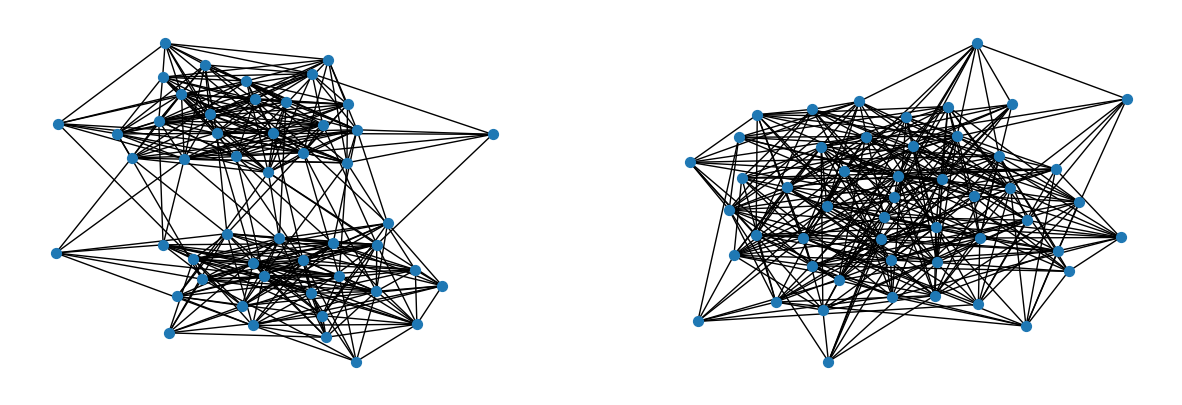

In [7]:
n_classes = 2
n_samples = 50
sizes0 = [n_samples//2, n_samples//2]
sizes1 = [n_samples//2, n_samples//2]#1/10, 9/10
p_inter = 0.5
p_outer = 0.05
probs0 = [[p_inter, p_outer], [p_outer, p_inter]]
probs1 = [[p_outer, p_inter], [p_inter, p_outer]]

plt.figure(figsize = (15, 5))
plt.subplot(121)
g = nx.stochastic_block_model(sizes0, probs0, seed=0)
nx.draw(g, node_size=50)

plt.subplot(122)
g = nx.stochastic_block_model(sizes1, probs1, seed=0)
nx.draw(g, node_size=50)

In [10]:
def sample_data(inlr_size, outlr_size, n_nodes, feat_type='degree'):
    #for a constant nb of nodes but extends to non constant nb of nodes 

    if feat_type=='constant': 
        dim_input=1
        feat= torch.ones(n_nodes,dim_input)
        samples_0 = [Data(x=feat, y=torch.tensor([0]), 
                  edge_index=stochastic_blockmodel_graph(sizes0, probs0)) for _ in range(inlr_size)]
        samples_1 = [Data(x=feat, y=torch.tensor([1]), 
                  edge_index=stochastic_blockmodel_graph(sizes1, probs1)) for _ in range(outlr_size)]

    elif feat_type=='degree': 
        samples_0 = [stochastic_blockmodel_graph(sizes0, probs0) for _ in range(inlr_size)]
        samples_1 = [stochastic_blockmodel_graph(sizes1, probs1) for _ in range(outlr_size)]
        feat_samples_0 = [degree(e[0], num_nodes=n_nodes) for e in samples_0]
        feat_samples_1 = [degree(e[0], num_nodes=n_nodes) for e in samples_1]

        samples_0 = [Data(x=x.view(-1,1), y=torch.tensor([0]), 
                  edge_index=e) for e,x in zip(samples_0, feat_samples_0)]
        samples_1 = [Data(x=x.view(-1,1), y=torch.tensor([1]), 
                  edge_index=e) for e,x in zip(samples_1, feat_samples_1)]
    else: raise ValueError("feat_type")
    
    return samples_0, samples_1

* Baseline 

Here if we do classif. on 2D features = max/sum of the degrees obvs it will work. 

> The point here is just to do an illustration. In practice, we have data where just looking at degrees will not work as well. In fact, we will look at the baseline only on the real data. 

In [4]:
test_size=500
calib_size=500
k=calib_size+test_size
null_size = k+calib_size
sparsity = 0.5

n0=null_size + int((1-sparsity)*test_size)
n1 = int(sparsity*test_size)

##### GNN

In [14]:
feat_type='degree'
dim_features=1
dim_target=2

In [ ]:
n_runs=50
batch_size=10
lr=0.001
clip=None

lvl_range=[0.05, 0.10, 0.2, 0.25, 0.3]

fdp, tdp={}, {}
for lvl in lvl_range: fdp[lvl]=[0.]*n_runs; tdp[lvl]=[0.]*n_runs

for i in range(n_runs):
    samples_0, samples_1 = sample_data(n0, n1, n_nodes=n_samples, feat_type=feat_type)

    train_loader, test_loader, calib_loader, val_loader = \
        make_train_test_set_from_list(samples_0, samples_1,
                        null_size=null_size, test_size=test_size, 
                        sparsity=sparsity, train_calib_ratio=k/null_size, 
                        batch_size=batch_size, val=False)
    
    model = GIN(dim_features=dim_features, dim_target=dim_target)
    #model = DiffPool(dim_features=dim_features, dim_target=dim_target) 
    model=train(train_loader, model, 
                val_dataset=val_loader, num_epochs=10, lr=lr, clip=clip, log=False) 

    test_preds, test_labels, test_acc = evaluate(test_loader, model) 
    null_preds,_,_ = evaluate(calib_loader, model)
    null_scores, test_scores = null_preds[:,1], test_preds[:,1]
    
    for lvl in lvl_range:
        rej_set = EmpBH(null_scores, test_scores, level=lvl/sparsity) 
    
        fdp[lvl][i], tdp[lvl][i] = get_fdp(test_labels, rej_set)

In [ ]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.plot(lvl_range, [np.mean(fdp[lvl]) for lvl in lvl_range])
plt.plot(lvl_range, lvl_range, ls='dashed', color='gray'); plt.ylim(0, 0.5)
plt.title("FDR")
plt.subplot(122)
plt.plot(lvl_range, [np.mean(tdp[lvl]) for lvl in lvl_range])
plt.ylim(0, 1)
plt.title("Power")
plt.show()


##### Oracle

In [136]:
def split_train_test(inliers, outliers, null_size, test_size):
    n_test1 = int( sparsity* test_size )
    n_test0 = test_size - n_test1
    
    random.shuffle(inliers)
    test0 = inliers[:n_test0]

    random.shuffle(outliers)
    test1 = outliers[:n_test1]

    null_dataset = inliers[n_test0:n_test0+null_size]
    test_dataset = test0 + test1
    
    test_labels = np.concatenate([np.zeros(n_test0), np.ones(n_test1)])
    
    return null_dataset, test_dataset, test_labels 

In [39]:
def compute_log_cond_density(adj, node_labels, conn_matrix):
    prob_matrix = node_labels.dot(conn_matrix).dot(node_labels.T)
    prob_matrix_f = np.where(adj ==1, prob_matrix, 0)
    return np.sum(prob_matrix_f)

def oracle_score(adj, node_labels, conn_matrix_0, conn_matrix_1):
    return compute_log_cond_density(adj, node_labels, conn_matrix_1) \
- compute_log_cond_density(adj, node_labels, conn_matrix_0)



In [40]:
def get_labels(partition):
    n_classes = len(partition)
    n_nodes = np.sum([len(x) for x in partition])
    
    labels= np.empty(n_nodes, n_classes)
    
    for q in n_classes:
        class_q = list(partition[q])
        labels[class_q, q] = 1
    return labels

In [41]:
#set aside training sample for fair comparison, we only want to compare the scoring

lvl_range=[0.05, 0.10, 0.2, 0.25, 0.3]

fdp, tdp={}, {}
for lvl in lvl_range: fdp[lvl]=[0.]*n_runs; tdp[lvl]=[0.]*n_runs

n_runs=50

for i in range(n_runs):
    g_0 = [nx.stochastic_block_model(sizes0, probs0) for _ in range(n0)]
    g_1 = [nx.stochastic_block_model(sizes1, probs1) for _ in range(n1)]
    
    adj_0, adj_1 = [nx.adjacency_matrix(g) for g in g_0], [nx.adjacency_matrix(g) for g in g_1]
    z_0, z_1 = [g.graph['partition'] for g in g_0], [g.graph['partition'] for g in g_1]
    
    labels=[0 for _ in range(25)] + [1 for _ in range(25)]
    z=np.eye(2)[labels]
    node_labels_0, node_labels_1 = [z for _ in range(len(z_0))], [z for _ in range(len(z_1))] #(!) 
    
    samples_0, samples_1 = list(zip(adj_0, node_labels_0)), list(zip(adj_1, node_labels_1))
    
    null_dataset, test_dataset, test_labels = split_train_test(samples_0, samples_1, null_size, test_size)
     
    null_scores = np.array([oracle_score(x[0].todense(), x[1], probs0, probs1) for  x in null_dataset])
    test_scores = np.array([oracle_score(x[0].todense(), x[1], probs0, probs1) for  x in test_dataset])
    
    for lvl in lvl_range:
        rej_set = EmpBH(null_scores, test_scores, level=lvl/sparsity) 
    
        fdp[lvl][i], tdp[lvl][i] = get_fdp(test_labels, rej_set)
    
#print("fdp:", np.mean(fdp), np.std(fdp))
#print("tdp", np.mean(tdp), np.std(tdp))

##### Graph kernel

In [8]:

class SVC_precomputed(object):
    def __init__(self):
        self.clf = SVC(kernel='precomputed')
        self.wl_kernel = WeisfeilerLehman(n_iter=5, normalize=True, base_graph_kernel=VertexHistogram)
    
    def fit(self, x_train, y_train):
        """
        x_train: list of nx graphs
        """
        for g in x_train:
            nx.set_node_attributes(g, {n:'a' for n in range(g.number_of_nodes())}, 'label')
        G_train=grakel.graph_from_networkx(x_train, node_labels_tag='label')
        
        K_train=self.wl_kernel.fit_transform(G_train)
        
        self.clf.fit(K_train, y_train)
    
    def decision_function(self, x_test): 
        for g in x_test:
            nx.set_node_attributes(g, {n:'a' for n in range(g.number_of_nodes())}, 'label')
        G_test=grakel.graph_from_networkx(x_test, node_labels_tag='label')
        
        K_test=self.wl_kernel.transform(G_test)
        
        return self.clf.decision_function(K_test)

In [19]:
lvl_range=[0.05, 0.10, 0.2, 0.25, 0.3]

n_runs=50

fdp, tdp={}, {}
for lvl in lvl_range: fdp[lvl]=[0.]*n_runs; tdp[lvl]=[0.]*n_runs


for i in range(n_runs):
    g_0 = [nx.stochastic_block_model(sizes0, probs0) for _ in range(n0)]
    g_1 = [nx.stochastic_block_model(sizes1, probs1) for _ in range(n1)]
    
    null_dataset, test_dataset, \
    test_labels = split_train_test(g_0, g_1, null_size, test_size)
    
    proc = AdaDetectERM(SVC_precomputed(), 
                        split_size=k/null_size, correction_type='storey', storey_threshold=0.5)
    
    for lvl in lvl_range:
        rej_set = proc.apply(test_dataset, lvl, null_dataset)  
    
        fdp[lvl][i], tdp[lvl][i] = get_fdp(test_labels, rej_set)

##### CAD with deep SVDD

In [5]:
feat_type='degree'
dim_features=1
dim_target=2

lvl_range=[0.05, 0.10, 0.2, 0.25, 0.3]
n_runs=50

fdp, tdp={}, {}
for lvl in lvl_range: fdp[lvl]=[0.]*n_runs; tdp[lvl]=[0.]*n_runs

for lvl in lvl_range:
    
    for i in range(n_runs):
        
        samples_0, samples_1 = sample_data(n0, n1, n_nodes=n_samples, feat_type=feat_type)
        
        train_loader, test_loader, calib_loader = CAD_make_train_test_set((samples_0, samples_1),
                        null_size=null_size, test_size=test_size, sparsity=sparsity, train_calib_ratio=k/null_size, 
                        batch_size=10, val=False)
        
        model = DeepSVDD()
        net = GIN(dim_features=dim_features, dim_target=dim_target)
        model.set_network(net)
        
        model.train(dataset=train_loader, lr=0.001, n_epochs=10) 
        
        test_scores, test_labels = model.test(test_loader)
        null_scores,_ = model.test(calib_loader)
        
        for lvl in lvl_range:
            rej_set = EmpBH(null_scores, test_scores, level=lvl/sparsity) 
    
            fdp[lvl][i], tdp[lvl][i] = get_fdp(test_labels, rej_set)
    

/Users/micarlhian/.pyenv/versions/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Data

In [2]:
dataset_name='DD'

In [3]:
dataset = TUDataset(root='./data/',name=dataset_name, use_node_attr=True)

AdaDetect

In [4]:
labels=np.array([x.y.numpy()[0] for x in dataset]).astype(float)

out_label=0

outlr_idx = np.arange(len(dataset))[labels==out_label]
inlr_idx = np.arange(len(dataset))[labels!=out_label]
outlr= dataset[outlr_idx]
inlr= dataset[inlr_idx]

print("Num of outliers:", len(outlr), "; Num of inliers:", len(inlr))

Num of outliers: 691 ; Num of inliers: 487


In [7]:
lvl_range=[0.2]
n_runs=50 

out_label=1

dim_features=dataset[0].x.shape[1]
dim_target=2

sparsity=0.5
test_size=100
k=200
calib_size=100
null_size=k+calib_size

fdp, tdp={}, {}
for lvl in lvl_range: fdp[lvl]=[0.]*n_runs; tdp[lvl]=[0.]*n_runs

n_nodes=[g.num_nodes for g in dataset]
k0=np.quantile(n_nodes, q=0.4) #for DGCNN

for i in range(n_runs):
        
        if i%5==0:print("[{}/{}]".format(i, n_runs))
        
        train_loader, test_loader, calib_loader = make_train_test_loaders(dataset,
                                                    null_size=null_size, test_size=test_size, 
                                                    out_label=out_label,
                                                    sparsity=sparsity, train_calib_ratio=k/null_size, 
                                                    batch_size=10)
        
        #model = GIN(dim_features=dim_features, dim_target=dim_target, aggregation='sum')
        #model= DiffPool(dim_features=dim_features, dim_target=dim_target)
        model= DGCNN(dim_features=dim_features, dim_target=dim_target, k=int(k0))
        
        
        model=train(train_loader, model, val_dataset=None, num_epochs=10, lr=0.001, clip=None,
           log=False, num_log_epochs=10)

        test_preds, test_labels, _ = evaluate(test_loader, model) 
        null_preds,_,_ = evaluate(calib_loader, model)
        null_scores, test_scores = null_preds[:,1], test_preds[:,1]
        
        for lvl in lvl_range:
            rej_set = adaptiveEmpBH(null_scores, test_scores, level=lvl, correction_type='storey')
            
    
            fdp[lvl][i], tdp[lvl][i] = get_fdp(test_labels, rej_set)

[0/50]


/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-p

[5/50]


/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-p

[10/50]


/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-p

[15/50]


/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-p

[20/50]


/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-p

[25/50]


/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-p

[30/50]


/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-p

[35/50]


/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-p

[40/50]


/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-p

[45/50]


/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/amarandon-carlhian/.pyenv/versions/3.10.8/envs/venv/lib/python3.10/site-p

In [8]:
print("FDR", np.mean(fdp[0.2]))
print("TDR", np.mean(tdp[0.2]))

FDR 0.1316005764408049
TDR 0.4036


In [103]:
def split_train_test(inliers, outliers, null_size, test_size, sparsity):
    n_test1 = int(sparsity* test_size )
    n_test0 = test_size - n_test1
    
    random.shuffle(inliers)
    test0 = inliers[:n_test0]

    random.shuffle(outliers)
    test1 = outliers[:n_test1]

    null_dataset = inliers[n_test0:n_test0+null_size]
    test_dataset = test0 + test1
    
    test_labels = np.concatenate([np.zeros(n_test0), np.ones(n_test1)])
    
    return null_dataset, test_dataset, test_labels 

In [102]:
#defines a graph classifier
class SVC_precomputed(object):
    def __init__(self):
        self.clf = SVC(kernel='precomputed')
        self.wl_kernel = WeisfeilerLehman(n_iter=5, normalize=True, base_graph_kernel=VertexHistogram)
    
    def fit(self, x_train, y_train):
        """
        x_train: list of grakel graphs
        """
        g_train=grakel.graph_from_networkx(x_train, node_labels_tag='x')
        K_train=self.wl_kernel.fit_transform(g_train)
        
        self.clf.fit(K_train, y_train)
    
    def decision_function(self, x_test): 
        """
        x_test: list of grakel graphs
        """
        g_test=grakel.graph_from_networkx(x_test, node_labels_tag='x')
        K_test=self.wl_kernel.transform(g_test)
        
        return self.clf.decision_function(K_test)

In [171]:
out_label=1
labels=np.array([x.y.numpy()[0] for x in dataset]).astype(float)

inlr, outlr=[], []
for g in dataset:
    g_nx=torch_geometric.utils.to_networkx(g, node_attrs='x')
    #nx.set_node_attributes(g_nx, {n:np.where(g_nx.nodes[n]['x'])[0][0] for n in range(g_nx.number_of_nodes())}, 'x')
    nx.set_node_attributes(g_nx, {n:'a' for n in range(g_nx.number_of_nodes())}, 'x')
    if g.y.numpy()[0]==out_label: outlr.append(g_nx)
    else: inlr.append(g_nx)
        


dim_features=dataset[0].x.shape[1]
dim_target=2

sparsity=0.5
test_size=500
m0= int(test_size * (1-sparsity)) 
max_calib_size = (len(inlr)-m0-test_size)//2
calib_size= np.minimum(max_calib_size, test_size) 
k= calib_size + test_size
null_size=k+calib_size

print("k", k); print("calib size", calib_size)


lvl_range=[0.2]

n_runs=100

fdp, tdp={}, {}
for lvl in lvl_range: fdp[lvl]=[0.]*n_runs; tdp[lvl]=[0.]*n_runs


for i in range(n_runs):
    if i%5==0:print("[{}/{}]".format(i, n_runs))
        
    null_dataset, test_dataset, test_labels = split_train_test(inlr, outlr, null_size, test_size, sparsity=0.5)
    #null_dataset, test_dataset must be lists or arrays 
   
    proc = AdaDetectERM(SVC_precomputed(), 
                        split_size=k/null_size, correction_type='storey', storey_threshold=0.5)
    
    for lvl in lvl_range:
        rej_set = proc.apply(test_dataset, lvl, null_dataset)  
    
        fdp[lvl][i], tdp[lvl][i] = get_fdp(test_labels, rej_set)

k 1000
calib size 500
[0/100]
[5/100]
[10/100]
[15/100]
[20/100]
[25/100]
[30/100]
[35/100]
[40/100]
[45/100]
[50/100]
[55/100]
[60/100]
[65/100]
[70/100]
[75/100]
[80/100]
[85/100]
[90/100]
[95/100]


1

In [177]:
print("fdp", np.mean(fdp[0.2]), np.std(fdp[0.2]))
print("tdp", np.mean(tdp[0.2]), np.std(tdp[0.2]))

fdp 0.05283324089058936 0.10264299135024171
tdp 0.01648 0.03645613254309897


0

In [170]:
print("fdp", np.mean(fdp[0.2]), np.std(fdp[0.2]))
print("tdp", np.mean(tdp[0.2]), np.std(tdp[0.2]))

fdp 0.06025798870975569 0.12483414771140892
tdp 0.011320000000000002 0.028171219355931337


In [182]:
(0.03645+0.028171)/2 

0.032310500000000006

In [20]:
dim_target=10

lvl_range=[0.05, 0.10, 0.15, 0.2, 0.25, 0.3]
n_runs=100

fdp, tdp={}, {}
for lvl in lvl_range: fdp[lvl]=[0.]*n_runs; tdp[lvl]=[0.]*n_runs

for i in range(n_runs):
        
        train_loader, test_loader, calib_loader = CAD_make_train_test_set(dataset,
                        null_size=null_size, test_size=test_size, 
                        out_label=out_label,
                        sparsity=sparsity, train_calib_ratio=k/null_size, 
                        batch_size=10)
        
        model = DeepSVDD()
        #net = GIN(dim_features=dim_features, dim_target=dim_target, aggregation='sum')
        net = DGCNN(dim_features=dim_features, dim_target=dim_target, k=5059)
        model.set_network(net)

        model.train(dataset=train_loader, lr=0.001, n_epochs=10) 
        
        test_scores, test_labels = model.test(test_loader)
        null_scores,_ = model.test(calib_loader)
        
        for lvl in lvl_range:
            rej_set = adaptiveEmpBH(null_scores, test_scores, level=lvl/sparsity, correction_type=None)
    
            fdp[lvl][i], tdp[lvl][i] = get_fdp(test_labels, rej_set)

/Users/micarlhian/.pyenv/versions/venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)
/Users/micarlhian/.pyenv/versions/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


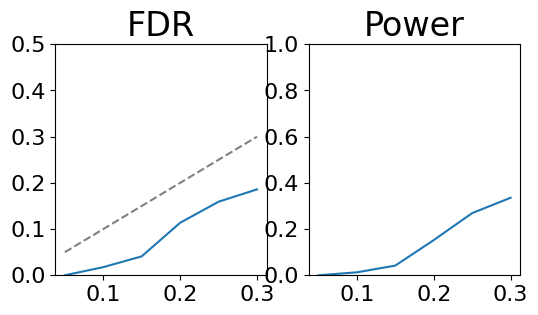

In [9]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.plot(lvl_range, [np.mean(fdp[lvl]) for lvl in lvl_range])
plt.plot(lvl_range, lvl_range, ls='dashed', color='gray'); plt.ylim(0, 0.5)
plt.title("FDR")
plt.subplot(122)
plt.plot(lvl_range, [np.mean(tdp[lvl]) for lvl in lvl_range])
plt.ylim(0, 1)
plt.title("Power")
plt.show()


In [132]:
print(np.mean(fdp[0.2]), np.std(fdp[0.2]))
print(np.mean(tdp[0.2]), np.std(tdp[0.2]))

0.09781124121919328 0.08620216949570676
0.3676 0.21097450082889163


In [64]:
proc_name = 'AdaDetect-DiffPool'
file_name=dataset_name+str(out_label) 

n_lvl=len(lvl_range)
df = pd.DataFrame({ 
                    'level': np.repeat(lvl_range, n_runs), 
                    'Procedure': np.repeat([proc_name], n_lvl*n_runs), 
                    'fdp': list(itertools.chain(*fdp.values())), 'tdp': list(itertools.chain(*tdp.values())),
})

df.to_csv('./tab/'+file_name+'_perf.csv', index=False, mode='a', header=True)

In [19]:
proc_name = 'CAD-GIN'
file_name=dataset_name+str(out_label) 

n_lvl=len(lvl_range)
df = pd.DataFrame({ 
                    'level': np.repeat(lvl_range, n_runs), 
                    'Procedure': np.repeat([proc_name], n_lvl*n_runs), 
                    'fdp': list(itertools.chain(*fdp.values())), 'tdp': list(itertools.chain(*tdp.values())),
})

df.to_csv('./tab/'+file_name+'_perf.csv', index=False, mode='a', header=False)

In [25]:
dataset_name='NCI1'

df=pd.read_csv("./tab/"+dataset_name+str(out_label)+"_perf.csv", header=0)

lvl_range = df['level'].unique()

marker = itertools.cycle(('^', 'v', 'd', 's')) 
color = itertools.cycle(('tab:blue', 'tab:cyan','tab:orange', 'tab:pink')) 

In [26]:
lvl=0.2
for proc in df['Procedure'].unique():
    df_proc = df[df['Procedure'] == proc] 
    print(proc)
    print(np.mean(df_proc[df_proc['level']==lvl]['fdp']), np.std(df_proc[df_proc['level']==lvl]['fdp']))
    print(np.mean(df_proc[df_proc['level']==lvl]['tdp']), np.std(df_proc[df_proc['level']==lvl]['tdp']))

AdaDetect-GIN
0.1537160754629994 0.22152413806866886
0.03808 0.07062799444979305
AdaDetect-DGCNN
0.1044538486360341 0.16913984213961322
0.050320000000000004 0.09325265465390249
CAD-GIN
0.10620346320346317 0.22360679821092885
0.00312 0.00811083226309113
CAD-DGCNN
0.04091666666666667 0.16621227642184955
0.0006 0.0026758176320519304


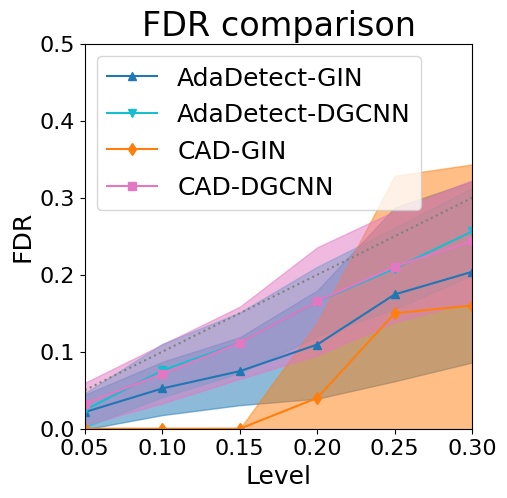

In [26]:

plt.figure(figsize=(5,5))

for proc in df['Procedure'].unique():
    df_proc = df[df['Procedure'] == proc] 
    
    y=np.array([np.mean(df_proc[df_proc['level']==lvl]['fdp']) for lvl in lvl_range])
    yerr=np.array([np.std(df_proc[df_proc['level']==lvl]['fdp']) for lvl in lvl_range])
    
    c=next(color)
    plt.plot(lvl_range, y, label=proc,
             marker=next(marker), 
            color=c,
            )
    plt.fill_between(lvl_range, y-yerr/2, y+yerr/2, alpha=0.5, color=c)
            
plt.plot(lvl_range, lvl_range, ls='dotted', color='grey')
plt.xlabel("Level")
plt.ylabel("FDR")
plt.ylim(0,0.5); plt.xlim(0.05, 0.3)
plt.title("FDR comparison")

plt.legend()

plt.savefig(dataset_name+"_fdr.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

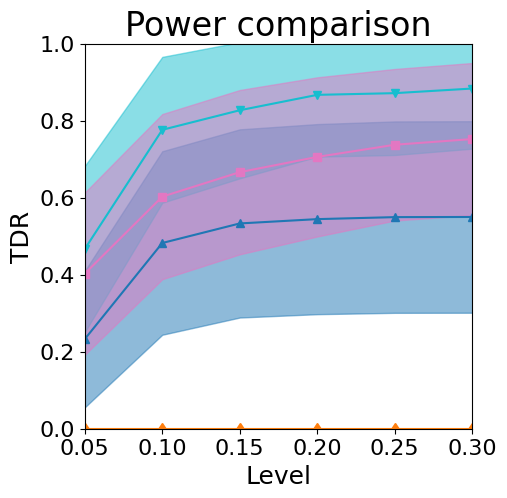

In [27]:
plt.figure(figsize=(5,5))


for proc in df['Procedure'].unique():
    df_proc = df[df['Procedure'] == proc] 
    
    y=np.array([np.mean(df_proc[df_proc['level']==lvl]['tdp']) for lvl in lvl_range])
    yerr=np.array([np.std(df_proc[df_proc['level']==lvl]['tdp']) for lvl in lvl_range])
    
    c=next(color)
    plt.plot(lvl_range, y, label=proc,
             marker=next(marker), 
            color=c,
            )
    plt.fill_between(lvl_range, y-yerr/2, y+yerr/2, alpha=0.5, color=c)
            
plt.xlabel("Level")
plt.ylabel("TDR")
plt.ylim(0,1); plt.xlim(0.05, 0.3)
plt.title("Power comparison")

#plt.legend()
plt.savefig(dataset_name+"_tdr.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [144]:

n_labels=2
dfs=[]
for out_label in range(n_labels): 
    dfs.append(pd.read_csv("./tab/"+dataset_name+str(out_label)+"_perf.csv", header=0))

lvl_range = dfs[0]['level'].unique()

marker = itertools.cycle(('^', 'v', 'd', 's'))
color = itertools.cycle(('tab:blue', 'tab:cyan','tab:orange', 'tab:pink'))

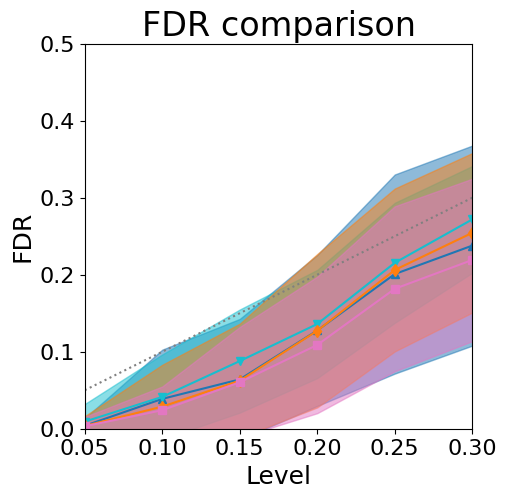

In [145]:
plt.figure(figsize=(5,5))

for proc in dfs[0]['Procedure'].unique():
    dfs_proc = [df[df['Procedure'] == proc] for df in dfs]
    
    y=np.array([np.mean(
        [np.mean(df_proc[df_proc['level']==lvl]['fdp']) for df_proc in dfs_proc]
    ) for lvl in lvl_range
    ])
    yerr=np.array([np.mean(
        [np.std(df_proc[df_proc['level']==lvl]['fdp']) for df_proc in dfs_proc]
    ) for lvl in lvl_range
    ])
    
    c=next(color)
    plt.plot(lvl_range, y, label=proc,
             marker=next(marker), 
            color=c,
            )
    plt.fill_between(lvl_range, y-yerr/2, y+yerr/2, alpha=0.5, color=c)
            
plt.plot(lvl_range, lvl_range, ls='dotted', color='grey')
plt.xlabel("Level")
plt.ylabel("FDR")
plt.ylim(0,0.5); plt.xlim(0.05, 0.3)
plt.title("FDR comparison")

#plt.legend()

plt.savefig(dataset_name+"_fdr.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

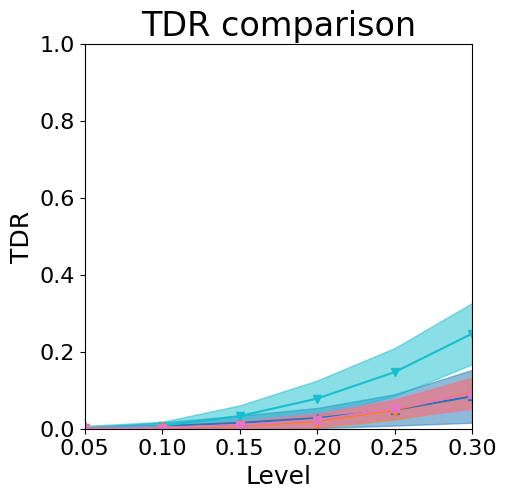

In [146]:
plt.figure(figsize=(5,5))

for proc in dfs[0]['Procedure'].unique():
    dfs_proc = [df[df['Procedure'] == proc] for df in dfs]
    
    y=np.array([np.mean(
        [np.mean(df_proc[df_proc['level']==lvl]['tdp']) for df_proc in dfs_proc]
    ) for lvl in lvl_range
    ])
    yerr=np.array([np.mean(
        [np.std(df_proc[df_proc['level']==lvl]['tdp']) for df_proc in dfs_proc]
    ) for lvl in lvl_range
    ])
    
    c=next(color)
    plt.plot(lvl_range, y, label=proc,
             marker=next(marker), 
            color=c,
            )
    plt.fill_between(lvl_range, y-yerr/2, y+yerr/2, alpha=0.5, color=c)
            
plt.xlabel("Level")
plt.ylabel("TDR")
plt.ylim(0,1.); plt.xlim(0.05, 0.3)
plt.title("TDR comparison")

ax=plt.gca()
#plt.legend()

plt.savefig(dataset_name+"_tdr.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

(0.0, 1.0, 0.0, 1.0)

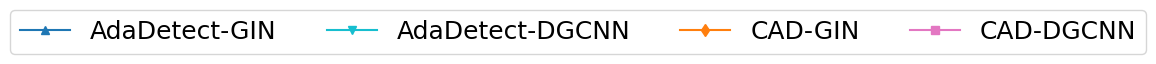

In [97]:
figsize = (3, .5)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', ncol=4)
# hide the axes frame and the x/y labels
ax_leg.axis('off')
#fig_leg.savefig('legend.png', bbox_inches='tight', dpi=300, transparent=True)

Supervised case

In [6]:
dim_features=89 
dim_target=2

model = GIN(dim_features=dim_features, dim_target=dim_target)
train_loader, test_loader, val_loader = supervised_make_train_test_set(dataset, train_ratio=0.8, test_ratio=0.1)
model=train(train_loader, model, val_dataset=val_loader, num_epochs=50, lr=0.01, clip=0.0)
_,_, acc=evaluate(test_loader, model)
print(acc)

Epoch:  1 ; Avg loss:  0.6484690407911936 ; Val acc: 0.5338983050847458
Epoch:  10 ; Avg loss:  0.5062858661015829 ; Val acc: 0.6440677966101694
Epoch:  20 ; Avg loss:  0.4404621531565984 ; Val acc: 0.5084745762711864
Epoch:  30 ; Avg loss:  0.38231920649607976 ; Val acc: 0.6016949152542372
Epoch:  40 ; Avg loss:  0.22056024720271428 ; Val acc: 0.6610169491525424
Epoch:  50 ; Avg loss:  0.18685558003683886 ; Val acc: 0.6271186440677966
0.6779661016949152


> at least for these hyper-parameters, GIN is not as good as DiffPool

In [5]:
from mpl_toolkits.axes_grid1 import ImageGrid

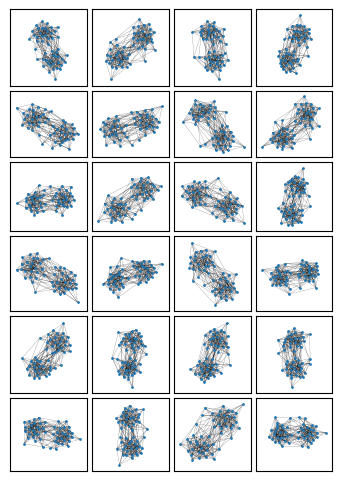

In [13]:
inlr_size=24

samples_0 = [nx.stochastic_block_model(sizes0, probs0, seed=42) for _ in range(inlr_size)]
np.random.shuffle(samples_0)

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(6, 4),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
                 )

for ax, g in zip(grid, samples_0):
    # Iterating over the grid returns the Axes.
    nx.draw(g, ax=ax, node_size=1, width=0.1)
    
    ax.set_axis_on()
    #ax.tick_params(bottom=False, top=False, left=False, right=False,
                  #labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    
    #if idx in sample_rej: 
        #ax.spines['bottom'].set_color('crimson')
        #ax.spines['top'].set_color('crimson') 
        #ax.spines['right'].set_color('crimson')
        #ax.spines['left'].set_color('crimson')
        #ax.spines["bottom"].set_linewidth(5)
        #ax.spines["top"].set_linewidth(5)
        #ax.spines["right"].set_linewidth(5)
        #ax.spines["left"].set_linewidth(5)

plt.savefig("graph_od_ex_null.png", dpi=300, bbox_inches='tight', transparent=True); plt.show()

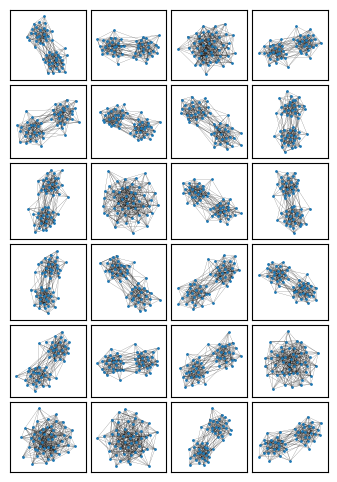

In [15]:
inlr_size=20
outlr_size=5

samples_0 = [nx.stochastic_block_model(sizes0, probs0, seed=0) for _ in range(inlr_size)]
samples_1 = [nx.stochastic_block_model(sizes1, probs1, seed=0) for _ in range(outlr_size)]

samples = samples_0 + samples_1
idx_samples = [_ for _ in range(inlr_size+outlr_size)]
sample_rej = np.concatenate([np.random.choice(idx_samples[:inlr_size], replace=False, size=int(0.1*inlr_size)),
                             np.random.choice(idx_samples[inlr_size:], replace=False, size=int(0.9*outlr_size))])

np.random.shuffle(idx_samples)

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(6, 4),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
                 )

for ax, idx in zip(grid, idx_samples):
    g=samples[idx]
    # Iterating over the grid returns the Axes.
    nx.draw(g, ax=ax, node_size=1, width=0.1)
    
    ax.set_axis_on()
    #ax.tick_params(bottom=False, top=False, left=False, right=False,
                  #labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    
    #if idx in sample_rej: 
        #ax.spines['bottom'].set_color('crimson')
        #ax.spines['top'].set_color('crimson') 
        #ax.spines['right'].set_color('crimson')
        #ax.spines['left'].set_color('crimson')
        #ax.spines["bottom"].set_linewidth(5)
        #ax.spines["top"].set_linewidth(5)
        #ax.spines["right"].set_linewidth(5)
        #ax.spines["left"].set_linewidth(5)

plt.savefig("graph_od_ex_test.png", dpi=300, bbox_inches='tight', transparent=True); plt.show()